# Quick Analysis of COVID-19 confirmed cases data

I've been quite frustrated with the data showing raw cases.  I'm much more interested in how many cases there are compared with the total population of a country or region.  The following adjusts the latest confirmed cases data to adjust for the total population of the country or region.  All numbers are percentages, and as you can tell, they are quite small at the moment.  But it's helpful for comparisons.

Data was sourced from: https://github.com/CSSEGISandData/COVID-19

Last Updated: 2020-03-25

In [1]:
%matplotlib inline
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dateparser
import seaborn as sns
sns.set(style="darkgrid")

In [2]:
pop_filename='./general_data/world-pop.csv'
pop = pd.read_csv(pop_filename)
pop['region'] = pop['region'].fillna('')
pop['population'] = pop['population'].apply(float)
pop = pop.set_index(['country', 'region'])

In [3]:
filename='./output.csv'
df = pd.read_csv(filename, skiprows=0)
df = df.drop(columns=['Deaths', 'Recovered'])

df['region'] = df['region'].fillna('')
df = df.set_index(['country', 'region'])#, 'date'])
df['date'] = df['date'].apply(pd.to_datetime)
df = pd.merge(df, pop,  how='inner', left_on=['country', 'region'], right_on=['country', 'region'])
df['ratio'] = df['Confirmed']/df['population'] * 100.0
df = df.fillna(0)
df['Confirmed'] = df['Confirmed'].apply(int)
df = df.reset_index()
def by_country(df, names):
    df = df.loc[names]
    df = df.fillna(0)
    for d in df.columns:
        if d in ['country', 'population']:
            continue
        p = df['population'].apply(float)
        v = df[d]
        v = v.apply(float)
        v = v.divide(p)*100.0
        df[d] = v
    df = df.transpose()
    return df


# Latest Number of Confirmed Cases

In [4]:
areas_of_interest = [('US', 'Texas'), ('US', 'Utah'), ('Canada', 'British Columbia'), ('Canada','Ontario')]
pd.pivot_table(df, values='Confirmed', index=['date'],
                    columns=['country', 'region'], aggfunc=np.sum)[areas_of_interest].tail()

country         US                  Canada        
region       Texas   Utah British Columbia Ontario
date                                              
2020-03-21   581.0  136.0            424.0   377.0
2020-03-22   643.0  162.0            424.0   425.0
2020-03-23   758.0  257.0            472.0   503.0
2020-03-24   955.0  298.0            617.0   588.0
2020-03-25  1229.0  340.0            617.0   688.0

# Canadian Provinces - Percentage of population confirmed

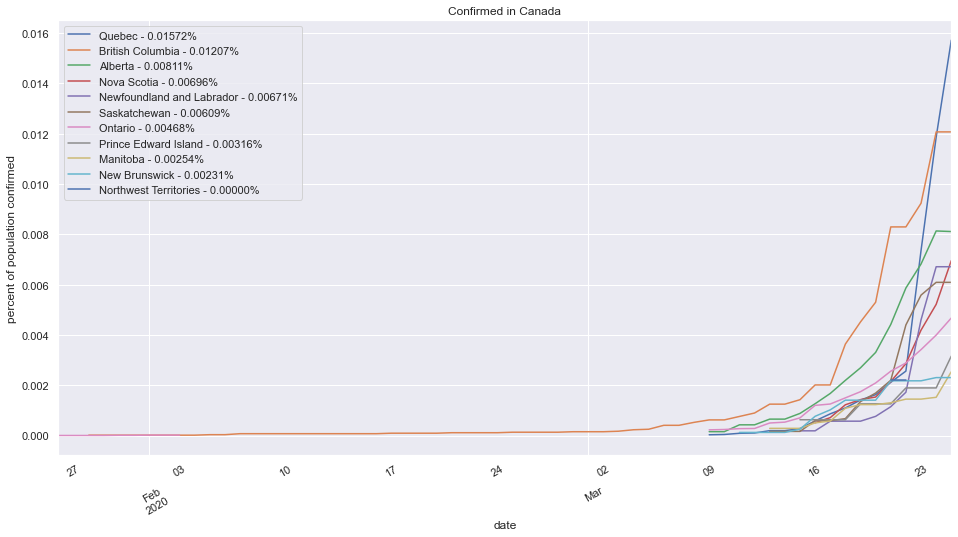

In [5]:
canada = df.loc[df['country'] == 'Canada']
canada = canada.drop(columns=['country'])

canada = canada.set_index(['date', 'region'])['ratio'].unstack(level=-1)
last_date = max(canada.index).date()
x = pd.DataFrame(canada.loc[last_date].fillna(0).sort_values(ascending=False))
canada = canada[x.index]

labels = list(map(lambda x: "%s - %.5f%%" % x, zip(x.index, x[x.columns[0]].to_list())))

ax = canada.plot(rot=30, figsize=(16,8), title='Confirmed in Canada')
ax.set_xlabel("date")
ax.set_ylabel("percent of population confirmed")
ax.legend(labels)
pass

In [6]:
canada.tail()

region,Quebec,British Columbia,Alberta,Nova Scotia,Newfoundland and Labrador,Saskatchewan,Ontario,Prince Edward Island,Manitoba,New Brunswick,Northwest Territories
date,,,,,,,,,,,
2020-03-21,0.002120,0.008296,0.004419,0.002148,0.001151,0.002200,0.002563,0.001265,0.001307,0.002180,0.002227
2020-03-22,0.002565,0.008296,0.005869,0.002865,0.001726,0.004401,0.002889,0.001897,0.001452,0.002180,0.002227
2020-03-23,0.007356,0.009235,0.006821,0.004195,0.004603,0.005585,0.003419,0.001897,0.001452,0.002180,NaN
2020-03-24,0.011865,0.012072,0.008135,0.005218,0.006713,0.006093,0.003997,0.001897,0.001524,0.002308,NaN
2020-03-25,0.015719,0.012072,0.008112,0.006957,0.006713,0.006093,0.004677,0.003161,0.002541,0.002308,NaN


# US States - Percentage of population confirmed

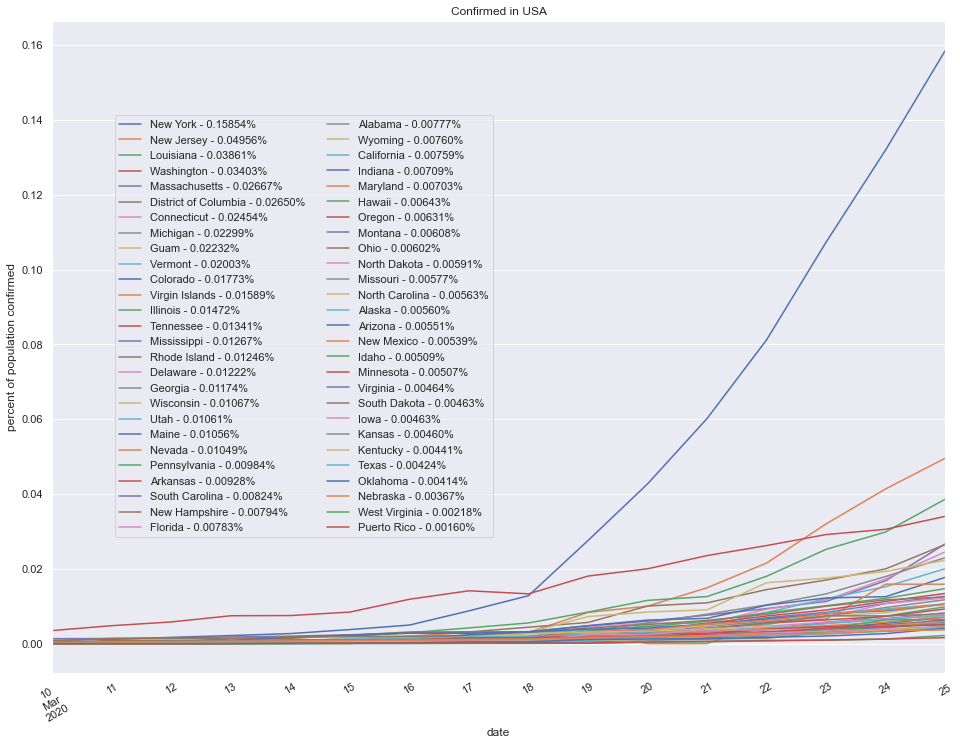

In [7]:
usa = df.loc[df['country'] == 'US'].loc[df['region'] != ''].groupby(by=['country', 'region', 'date']).sum()
last_date = str(max(usa.index.get_level_values(2)).date())
last_date
idx = pd.IndexSlice

x = usa.loc[idx[:,:,[last_date]], idx[['ratio', 'Confirmed', 'population']]].sort_values(by=['ratio'], ascending=False)
labels = list(map(lambda x: "%s - %.5f%%" % (x[0][1], x[1]), zip(x.index, x[x.columns[0]].to_list())))
rows = list(filter(lambda x: str(x[2]) > '2020-03-07', usa.index))
usa = usa.loc[rows]
usa = usa.reset_index()
usa = usa.drop(columns=['country'])

usa = pd.pivot_table(usa, values='ratio', index=['date'],
                     columns=['region'], aggfunc=np.sum).fillna(0)[x.index.get_level_values(1)]

ax = usa.plot(rot=30, figsize=(16,12), title='Confirmed in USA')
ax.set_xlabel("date")
ax.set_ylabel("percent of population confirmed")
ax.legend(labels, bbox_to_anchor=(0.5, 0.2), ncol=2)
pass

# Percentage of Population Confirmed - Top 12 US States

In [8]:
x['millions'] = x['population'].divide(1000000.0).apply(int)
x[:12][['Confirmed', 'ratio', 'millions']]

Confirmed     ratio  millions
country region               date                                     
US      New York             2020-03-25      30841  0.158537      1225
        New Jersey           2020-03-25       4402  0.049560       195
        Louisiana            2020-03-25       1795  0.038612       302
        Washington           2020-03-25       2591  0.034025       304
        Massachusetts        2020-03-25       1838  0.026667       110
        District of Columbia 2020-03-25        187  0.026497         0
        Connecticut          2020-03-25        875  0.024542        28
        Michigan             2020-03-25       2296  0.022990       838
        Guam                 2020-03-25         37  0.022320         0
        Vermont              2020-03-25        125  0.020032         9
        Colorado             2020-03-25       1021  0.017730       374
        Virgin Islands       2020-03-25         17  0.015891         0

# Top Countries Confirmed by Percentage of Population


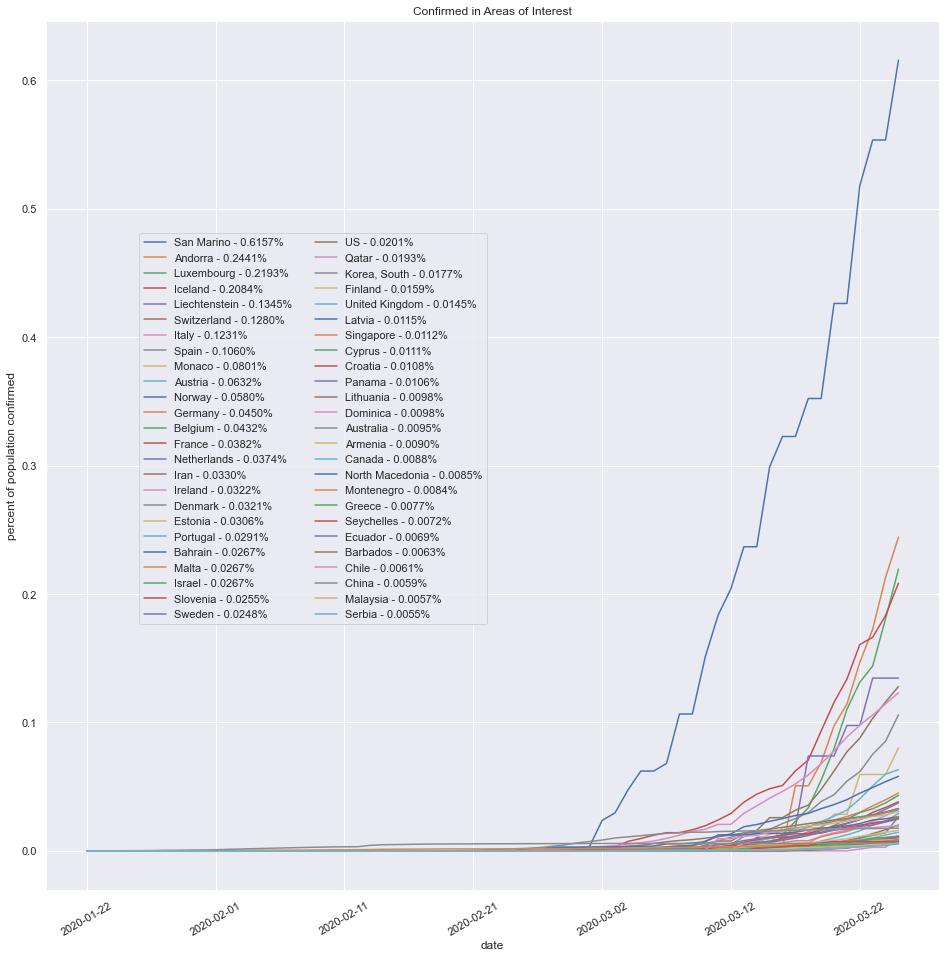

In [9]:
filename = "csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
world = pd.read_csv(filename, skiprows=0)
world = world.drop(columns=['Lat', 'Long']).rename(columns={"Province/State": "region", "Country/Region": "country"})
world['region'] = world['region'].fillna("")
world = world.groupby(by=['country']).sum()
world['region'] = ""

world = pd.merge(world, pop,  how='inner', left_on=['country', 'region'], right_on=['country', 'region'])
world = world.drop(columns=['region'])
# rename columns
columns = dict([(d, str(dateparser.parse(d).date())) for d in world.columns if d not in ['population']])
world = world.rename(columns=columns)

world_pop = world.copy()

for d in world.columns:
    if d in ['country', 'population']:
        continue
    p = world['population']
    dd = str(dateparser.parse(d).date())
    world_pop[dd] = world[d].divide(p)*100.0
world = world.drop(columns=['population'])
world_pop = world_pop.drop(columns=['population'])
last_date = max(world_pop.columns)
world_pop = world_pop.sort_values(by=[last_date], ascending=False)
last = world_pop[last_date]

world_pop = world_pop.transpose()

countries = last[:50]
labels = list(map(lambda x: "%s - %.4f%%" % (x[0], x[1]), zip(countries.index, countries.values)))
ax = world_pop[countries.index].plot(rot=30, figsize=(16,16), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.5, 0.3), ncol=2)
ax.set_xlabel("date")
ax.set_ylabel("percent of population confirmed")
pass


# Comparison of areas of interest - Percent of Population confirmed

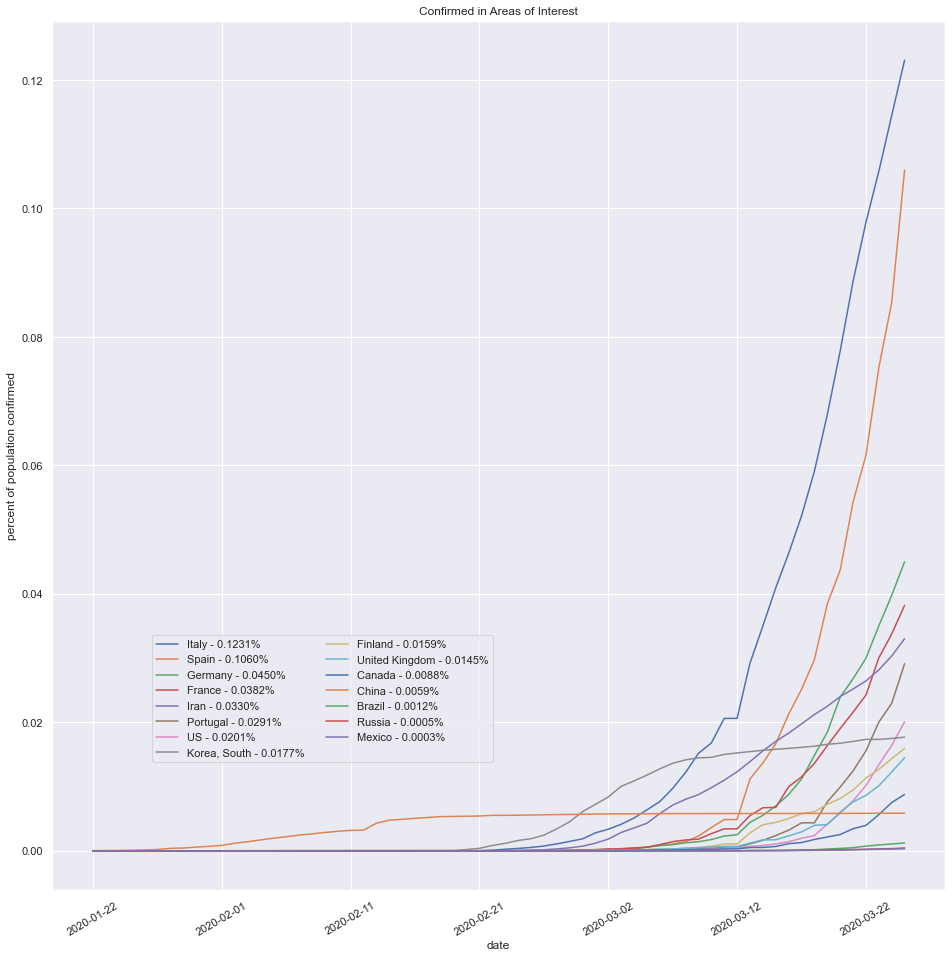

In [10]:
areas_of_interest = ['US', 'Canada', 'Iran', 'China', 'Korea, South', 'Italy', 'Spain',
                    'Germany', 'France', 'United Kingdom', 'Russia', 'Finland', 'Portugal',
                    'Brazil', 'Mexico']

areas = list(filter(lambda x: x in areas_of_interest, last.index))

countries = last[areas]
labels = list(map(lambda x: "%s - %.4f%%" % (x[0], x[1]), zip(countries.index, countries.values)))
ax = world_pop[countries.index].plot(rot=30, figsize=(16,16), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.5, 0.3), ncol=2)
ax.set_xlabel("date")
ax.set_ylabel("percent of population confirmed")
pass

In [11]:
world_pop[countries.index].tail(6)

country,Italy,Spain,Germany,France,Iran,Portugal,US,"Korea, South",Finland,United Kingdom,Canada,China,Brazil,Russia,Mexico
2020-03-20,0.077809,0.043682,0.023934,0.019045,0.024015,0.009920,0.005838,0.016756,0.008155,0.006037,0.002545,0.005834,0.000379,0.000175,0.000130
2020-03-21,0.088659,0.054306,0.026786,0.021591,0.025196,0.012449,0.007791,0.017041,0.009478,0.007621,0.003446,0.005838,0.000487,0.000212,0.000161
2020-03-22,0.097860,0.061570,0.029994,0.024248,0.026452,0.015562,0.010171,0.017354,0.011345,0.008641,0.003964,0.005847,0.000738,0.000254,0.000199
2020-03-23,0.105785,0.075199,0.035038,0.030040,0.028177,0.020035,0.013402,0.017354,0.012686,0.010116,0.005634,0.005852,0.000919,0.000303,0.000250
2020-03-24,0.114471,0.085363,0.039777,0.033771,0.030331,0.022973,0.016426,0.017502,0.014353,0.012279,0.007529,0.005858,0.001073,0.000343,0.000291
2020-03-25,0.123092,0.105974,0.045007,0.038216,0.033028,0.029129,0.020105,0.017695,0.015948,0.014499,0.008773,0.005863,0.001219,0.000455,0.000321


# Select US States and Canadian Provinces
## Percentage of population confirmed

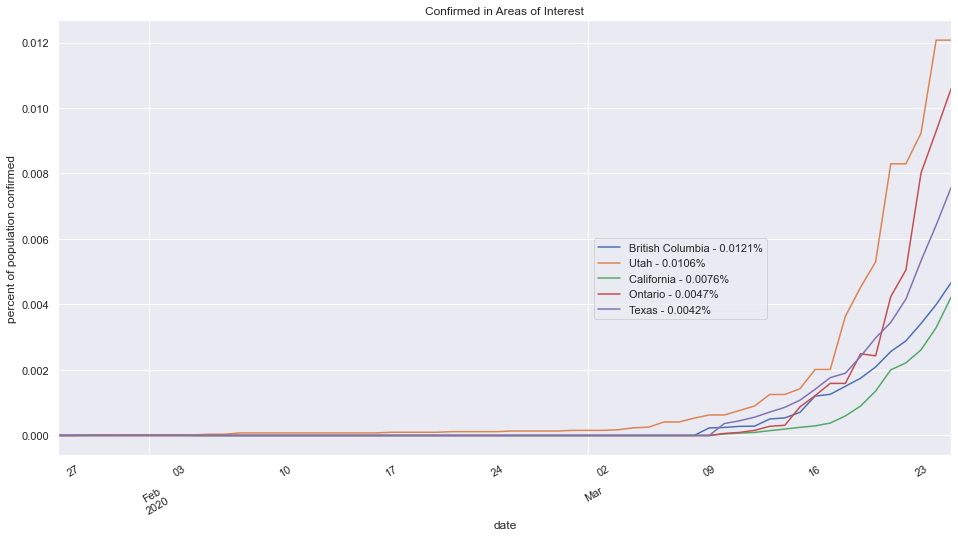

In [12]:
interest = [('US', 'Texas'), ('US', 'Utah'), ('US', 'California'), ('Canada', 'British Columbia'), ('Canada', 'Ontario')]

def f(x):
    if x[0:2] not in interest:
        return False
    
    return True

usa_areas = list(filter(f, usa.columns))
canada_areas = list(filter(f, canada.columns))

u = usa[['Texas', 'Utah', 'California']]
c = canada[['Ontario', 'British Columbia']]

x = pd.DataFrame()
for column in c.columns:
    x[column] = c[column]
for column in u.columns:
    x[column] = u[column]

last_date = max(x.index)
last = x.loc[last_date].sort_values(ascending=False)
labels = ["%s - %.4f%%" % v for v in zip(last.index, last.values)]
x = x.fillna(0)
ax = x.plot(rot=30, figsize=(16,8), title='Confirmed in Areas of Interest')
ax.legend(labels, bbox_to_anchor=(0.8, 0.3))
ax.set_xlabel("date")
ax.set_ylabel("percent of population confirmed")
pass